In [101]:
import pandas as pd
import regex as re
import msoffcrypto
import openpyxl
from io import BytesIO
#pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import  shapiro
import scipy.stats as st
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error

## 1)Loading the data

In [102]:
#Load all the data into dataframes from our documents
censo = pd.read_csv(r"Comercial_Censo.csv",sep=";", encoding='latin1') #Population information
meteo=pd.read_csv(r"Comercial_Meteorología.csv") #Meteo information
com_test=pd.read_csv(r"Comercial_Test.csv",sep=";", encoding='latin1') #Main Test Dataset with sales information
ventas=pd.read_csv(r"Comercial_Ventas.csv",sep=";", encoding='latin1') # Main Train Dataset with sales information

#The excel document is encrypted, we need to decrypt it
file_path = r"Comercial_ParqueVehiculos1.xlsx"
password = "IndesIA2022!"

with open(file_path, 'rb') as file:
    encrypted_file = msoffcrypto.OfficeFile(file)
    encrypted_file.load_key(password=password)
    
    decrypted_file = BytesIO()
    encrypted_file.decrypt(decrypted_file)
    decrypted_file.seek(0)

    #We load the data from the excel file differenciating the years
    parque2016 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=0, header=2)
    parque2017 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=1, header=2)
    parque2018 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=2, header=2)


# Data Cleaning

In [103]:
censo.head()

,Municipio,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
0,"15 Coruña, A",1.119.351,1.120.294,1.122.799,1.127.196,1.132.735,1.138.161,1.143.911,1.147.124,1.146.458,1.145.488,1.139.121
1,15001 Abegondo,5.454,5.467,5.533,5.586,5.585,5.664,5.709,5.709,5.765,5.798,5.822
2,15002 Ames,31.278,30.835,30.544,30.267,29.975,29.689,29.331,28.852,27.900,26.983,25.818
3,15003 Aranga,1.894,1.935,1.982,1.997,2.033,2.051,2.072,2.113,2.126,2.142,2.181
4,15004 Ares,5.671,5.658,5.672,5.743,5.741,5.801,5.839,5.801,5.705,5.673,5.682


## 1) Cleaning Censo Dataset

Using Regular Expression in order to remove digits inside the "Municipio" column.
In addition we just flatten this dataset so that we have three columns: "Municipio", "Population" and "Year" for easier interpretation

In [104]:
def clean_name(text):
    return re.sub(r'^\d+\s*', '', text).strip()
censo['Municipio'] = censo['Municipio'].apply(clean_name)
dfs = []
#Lets transform the dataframe to handle easier the data
for year in censo.columns[1:]:
    temp_df = censo[['Municipio', year]].copy()
    temp_df.columns = ['Municipio', 'Total_Poblacion']
    temp_df['Año'] = year
    dfs.append(temp_df)

df_concatenated = pd.concat(dfs, ignore_index=True)
censo=df_concatenated

In [105]:
meteo.head()

,Unnamed: 0,altitud,dir,fecha,horaPresMax,horaPresMin,horaracha,horatmax,horatmin,indicativo,...,prec,presMax,presMin,provincia,racha,sol,tmax,tmed,tmin,velmedia
0,0,58,18,2016-01-01,00,11,10:50,13:10,23:59,1387,...,"7,0","1012,5","998,3",A CORUA,"19,4","1,8","15,3","12,4","9,4","5,8"
1,1,58,22,2016-01-02,11,24,01:20,14:30,06:20,1387,...,"2,2","1014,3","1006,2",A CORUA,"13,6","5,7","14,0","11,2","8,4","4,2"
2,2,58,25,2016-01-03,00,13,13:20,Varias,00:00,1387,...,"12,0","1006,2","996,9",A CORUA,"19,2","0,0","15,6","14,0","12,3","5,8"
3,3,58,29,2016-01-04,Varias,14,15:00,00:00,23:40,1387,...,"11,2","999,9","994,5",A CORUA,"17,8","0,0","13,0","11,0","9,1","6,7"
4,4,58,99,2016-01-05,23,06,Varias,13:50,11:00,1387,...,"7,6","1006,2","998,6",A CORUA,"21,4","1,9","11,2","9,5","7,8","10,8"


## 2) Cleaning the Meteo Dataset
1. We remove the column "Unnamed" from the meteo dataset.
2. Drop useless columns
3. Trasform the date in datetime
4. Creating 4 variables corresponding to the Weekday, Day, Month and Year from the date column
5. Check for null values and drop them

In [106]:
# 1. Dropping the unnamed columns
meteo=meteo.drop(columns=["Unnamed: 0"])
# 2. Dropping useless columns
meteo.drop(columns=["provincia","indicativo","nombre"],inplace=True)

# 3. Transforming the date to datetime
meteo["fecha"]=pd.to_datetime(meteo["fecha"])

# 4. Creating new date columns
meteo['Year'] = pd.DatetimeIndex(meteo['fecha']).year
meteo['Month'] = pd.DatetimeIndex(meteo['fecha']).month 
meteo['Day'] = pd.DatetimeIndex(meteo['fecha']).day 
meteo['Weekday'] = pd.DatetimeIndex(meteo['fecha']).weekday

# 5. Checking and dropping null values
meteo.isna().sum()
meteo.loc[meteo.isna().any(axis=1)]
meteo=meteo.dropna()

## 2) Cleaning Test Dataset

1. Converting the Day column to datetime
2. Creating 4 variables corresponding to the Weekday, Day, Month and Year from the date column
3. Incorporating a dataset that national holidays in Spain. Dataset calles "fiestas2019"
4. Making a mapping for the month for the "fiestas2019"
5. Applying the mapping to the dataset
6. Creating a new date column inside the "fiestas2019" 
7. Adding the national holidays to the test dataset

In [107]:
com_test.head()

,Unnamed: 0,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre
0,1,2019-01-01,95,"43,31748953","-8,47923782","1,199","0,0939126888063492",ES4
1,2,2019-01-01,GOA,"43,31748953","-8,47923782","1,159","0,233796029661409",ES4
2,3,2019-01-02,95,"43,31748953","-8,47923782","1,199","0,111861605268607",ES4
3,4,2019-01-02,GOA,"43,31748953","-8,47923782","1,159","0,510476600506945",ES4
4,5,2019-01-03,95,"43,31748953","-8,47923782","1,199","0,133608521518117",ES4


In [108]:
# 1. Converting the Dia column to datetime
com_test["Dia"] = pd.to_datetime(com_test["Dia"])

# 2. Creating new date columns
com_test['Year'] = pd.DatetimeIndex(com_test['Dia']).year
com_test['Month'] = pd.DatetimeIndex(com_test['Dia']).month 
com_test['Day'] = pd.DatetimeIndex(com_test['Dia']).day 
com_test['Weekday'] = pd.DatetimeIndex(com_test['Dia']).weekday

# 3. Importing a new dataset with the holidays in Spain in 2019 from the Spain Goverment website
file_path = 'Festivos_España_2019.csv'
fiestas2019 = pd.read_csv(file_path)
fiestas2019['Año'] = 2019
fiestas2019.drop(columns="Descripcion",inplace=True)

# 4. Creating a mapping dictionary for the months to a better performance
month_mapping = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# 5. Create a new 'Fecha' column by combining 'Mes', 'Dia', and 'Año'
fiestas2019['Mes'] = fiestas2019['Mes'].map(month_mapping)
fiestas2019['Fecha'] = pd.to_datetime(fiestas2019['Dia'].astype(str) + '-' + fiestas2019['Mes'].astype(str) + '-' + fiestas2019['Año'].astype(str), format='%d-%m-%Y')
# 5a. Drop the redundant columns
fiestas2019.drop(columns=['Mes', 'Dia', 'Año'], inplace=True)

# 6. Adding a new column on the test dataset 
com_test['Fiesta'] = com_test['Dia'].isin(fiestas2019['Fecha']).astype(int)

In [109]:
print(ventas)

              Dia Producto      Latitud     Longitud    PVP      VentasN  \
0      01/01/2016       95  43,31748953  -8,47923782  1,169   0,05074742   
1      01/01/2016      GOA  43,31748953  -8,47923782  1,009  0,186169968   
2      02/01/2016       95  43,31748953  -8,47923782  1,169  0,173695862   
3      02/01/2016      GOA  43,31748953  -8,47923782  1,009    0,4597959   
4      03/01/2016       95  43,31748953  -8,47923782  1,169   0,13236665   
...           ...      ...          ...          ...    ...          ...   
26299  29/12/2018      GOA  43,33886779  -8,39372721  1,159  0,405144765   
26300  30/12/2018       95  43,33886779  -8,39372721  1,209  0,209279224   
26301  30/12/2018      GOA  43,33886779  -8,39372721  1,159  0,403786954   
26302  31/12/2018       95  43,33886779  -8,39372721  1,209  0,253878492   
26303  31/12/2018      GOA  43,33886779  -8,39372721  1,159  0,410514985   

      Nombre  Day      Month  Year  Weekday     Fiesta  
0        ES4    1      enero  

## 3) Cleaning Ventas Dataset

1. Dummifying the column'Fiesta' 
2. Creating 4 variables corresponding to the Weekday, Day, Month and Year from the date column
3. Transform the PVP object type to a float type and clip the outlier to the maximum value
4. Impute the missing values (1200 NaN) in the PVP column with its average

In [110]:
# 1. Dummifying the column Fiesta
ventas["Fiesta"]= ventas["Fiesta"].apply(lambda x: 1 if pd.notna(x) else 0)

# 2. Creating the 4 date columns
ventas['Year'] = pd.DatetimeIndex(ventas['Dia']).year
ventas['Month'] = pd.DatetimeIndex(ventas['Dia']).month 
ventas['Day'] = pd.DatetimeIndex(ventas['Dia']).day 
ventas['Weekday'] = pd.DatetimeIndex(ventas['Dia']).weekday

# 3. Transform PVP in float 
ventas['PVP'] = ventas['PVP'].str.replace(',', '.').astype(float)
# 3a. Clip the PVP outlier to its maximum
ventas["PVP"]=ventas["PVP"].clip(upper=ventas["PVP"].quantile(0.99)) 

# 4. Check for missing values inside the PVP column. Seeing that is a small amount of data we can impact encode those values with the mean of the column
print(ventas["PVP"].isna().sum())
# 4a. Let's impact encode those values inside the PVP column that are missing with the mean of the column
ventas["PVP"]=ventas["PVP"].fillna(ventas["PVP"].mean())

1224


In [111]:
parque2016.head()

,PROVINCIAS,MUNICIPIOS,CAMIONES y\nFURGONETAS,AUTOBUSES,TURISMOS,MOTOCICLETAS,TRACTORES\nINDUSTRIALES,REMOLQUES y\nSEMIRREMOLQUES,OTROS\nVEHÍCULOS,TOTAL
0,Coruña (A),Abegondo,606,0,3515,313,34,76,91,4635
1,Coruña (A),Ames,1524,1,14263,1053,42,109,155,17147
2,Coruña (A),Aranga,194,1,1221,70,14,23,34,1557
3,Coruña (A),Ares,201,0,2728,226,5,19,28,3207
4,Coruña (A),Arteixo,2827,49,16303,1531,130,253,450,21543


## 4) Cleaning Parque Dataset

1. Replace the "\n" with space in the columns titles
2. Drop Redundant column "PROVINCIAS" which has a unique value= Coruña
3. Rename the columns with the year in order to avoid confusion.
4. The parque2016 dataset has the columns "Camiones" and "Furgonetas" merged, so we will merge in the same way also for parque2017 and parque2018.
5. Rename the columns for Merging on the common variable "MUNICIPIOS"
6. Merge the datasets in order to have a single one called "parque"

In [112]:
# 1. Replace the \n in the columns
parque2016.columns=parque2016.columns.str.replace("\n"," ")
parque2017.columns=parque2017.columns.str.replace("\n"," ")
parque2018.columns=parque2018.columns.str.replace("\n"," ")

# 2. Drop the PROVINCIAS column
parque2016=parque2016.drop(columns=["PROVINCIAS"])
parque2017=parque2017.drop(columns=["PROVINCIAS"])
parque2018=parque2018.drop(columns=["PROVINCIAS"])

# 3. Adding a suffix in order to differentiate the years
parque2016=parque2016.add_suffix("_2016")
parque2017=parque2017.add_suffix("_2017")
parque2018=parque2018.add_suffix("_2018")

# 4. This dataset (parque2016) has the Camiones and furgonetas merged, while the others it has them separated. We will merge them in the other datasets due we dont have the data about the individual types of vehicles

parque2017["CAMIONES y FURGONETAS_2017"]=parque2017["CAMIONES_2017"]+parque2017["FURGONETAS_2017"]
parque2017=parque2017.drop(columns=["CAMIONES_2017","FURGONETAS_2017"])
parque2018["CAMIONES y FURGONETAS_2018"]=parque2018["CAMIONES_2018"]+parque2018["FURGONETAS_2018"]
parque2018=parque2018.drop(columns=["CAMIONES_2018","FURGONETAS_2018"])

# 5. Rename the columns to merge the datasets
parque2016 = parque2016.rename(columns={"MUNICIPIOS_2016": "MUNICIPIOS"})
parque2017 = parque2017.rename(columns={"MUNICIPIOS_2017": "MUNICIPIOS"})
parque2018 = parque2018.rename(columns={"MUNICIPIOS_2018": "MUNICIPIOS"})

# 6. Lets create a single dataset with the data from the 3 years
parque_m=pd.merge(parque2016,parque2017,how="inner",on="MUNICIPIOS")
parque=pd.merge(parque_m,parque2018,how="inner",on="MUNICIPIOS")
parque.columns=parque.columns.str.capitalize()

years = ['2016', '2017', '2018']

long_format = []
for index, row in parque.iterrows():
    for year in years:
        long_format.append({
            'Municipios': row['Municipios'],
            'year': year,
            'Camiones y furgonetas': row[f'Camiones y furgonetas_{year}'],
            'Autobuses': row[f'Autobuses_{year}'],
            'Turismos': row[f'Turismos_{year}'],
            'Motocicletas': row[f'Motocicletas_{year}'],
            'Tractores industriales': row[f'Tractores industriales_{year}'],
            'Remolques y semirremolques': row[f'Remolques y semirremolques_{year}'],
            'Otros vehículos': row[f'Otros vehículos_{year}'],
            'Total': row[f'Total_{year}'],
        })

parque = pd.DataFrame(long_format)
parque=parque.replace("Coruña (A) ( municipio sin especificar)","Otro")

## 4.1 Checking the results 

In [113]:
parque['Municipios'].unique()   

array(['Abegondo', 'Ames', 'Aranga', 'Ares', 'Arteixo', 'Arzúa',
       'Baña, A', 'Bergondo', 'Betanzos', 'Boimorto', 'Boiro',
       'Boqueixón', 'Brión', 'Cabana de Bergantiños', 'Cabanas',
       'Camariñas', 'Cambre', 'Capela, A', 'Carballo', 'Cariño',
       'Carnota', 'Carral', 'Cedeira', 'Cee', 'Cerceda', 'Cerdido',
       'Coirós', 'Corcubión', 'Coristanco', 'Otro', 'Coruña, A',
       'Culleredo', 'Curtis', 'Dodro', 'Dumbría', 'Fene', 'Ferrol',
       'Fisterra', 'Frades', 'Irixoa', 'Laracha, A', 'Laxe', 'Lousame',
       'Malpica de Bergantiños', 'Mazaricos', 'Mañón', 'Melide', 'Mesía',
       'Miño', 'Moeche', 'Monfero', 'Mugardos', 'Muros', 'Muxía', 'Narón',
       'Neda', 'Negreira', 'Noia', 'Oleiros', 'Ordes', 'Oroso',
       'Ortigueira', 'Outes', 'Oza-Cesuras', 'Paderne', 'Padrón',
       'Pino, O', 'Pobra do Caramiñal, A', 'Ponteceso', 'Pontedeume',
       'Pontes de García Rodríguez, As', 'Porto do Son', 'Rianxo',
       'Ribeira', 'Rois', 'Sada', 'San Sadurniño', 'S

In [114]:
ventas.head()

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday,Fiesta
0,01/01/2016,95,"43,31748953","-8,47923782",1.169,"0,05074742",ES4,1,1,2016,4,1
1,01/01/2016,GOA,"43,31748953","-8,47923782",1.009,"0,186169968",ES4,1,1,2016,4,1
2,02/01/2016,95,"43,31748953","-8,47923782",1.169,"0,173695862",ES4,1,2,2016,0,0
3,02/01/2016,GOA,"43,31748953","-8,47923782",1.009,"0,4597959",ES4,1,2,2016,0,0
4,03/01/2016,95,"43,31748953","-8,47923782",1.169,"0,13236665",ES4,1,3,2016,1,0


## 5) Creating a Station Dataset

The objective of this part is to create a bridge dataset helping us to match the "Longitud" and "Latitud" with the Municipality

1. Create a stations datasets with just Longitud and Lagtitud (Also dropping nan inside these two values)
2. Drop duplicates in order to have like a "Primary key" table
3. Setting the index to the name of the stations
4.  Replace commas with dots in the latitude and longitude columns and convert them to floats in order to apply a function taking a certificate from the web able to match the longitud and latitude to a municpality inside the "A Coruña" region.

5. Apply the function and check the results 

In [115]:
import pandas as pd
import requests
import time

# Assuming 'ventas' is your original DataFrame
# Drop irrelevant columns and remove rows with missing latitude or longitude
stations = ventas.drop(columns=['Producto', 'PVP', 'VentasN', 'Day', 'Month', 'Year', 'Weekday', 'Fiesta', 'Dia'])
stations.dropna(subset=["Latitud", "Longitud"], inplace=True)

# Check for duplicates based on latitude and longitude
stations.drop_duplicates(subset=["Latitud", "Longitud"], inplace=True)

# Convert latitude and longitude to float, replacing commas with dots
stations['Latitud'] = stations['Latitud'].str.replace(",", ".").astype(float)
stations['Longitud'] = stations['Longitud'].str.replace(",", ".").astype(float)

# Function to get municipality using Nominatim
def get_municipality(lat, lon):
    retries = 3  # Number of retries
    delay = 1  # Delay in seconds between retries
    for _ in range(retries):
        try:
            url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&accept-language=en&addressdetails=1"
            headers = {
                'User-Agent': 'Your-App-Name',  # Replace with a meaningful user-agent
                'Accept-Language': 'en-US',
                'Accept': 'application/json'
            }
            response = requests.get(url, headers=headers)
            
            if response.status_code == 200:
                data = response.json()
                if 'address' in data:
                    address = data['address']
                    # Check for city, town, village, or county in address
                    return address.get('city') or address.get('town') or address.get('village') or address.get('county')
                else:
                    print(f"No 'address' found in response data: {data}")
            else:
                print(f"Request failed with status code: {response.status_code}")
        
        except Exception as e:
            print(f"Error occurred: {e}")
        
        time.sleep(delay)  # Delay before retrying
    
    return None

# Apply the function to each row in the DataFrame
stations["Municipio"] = stations.apply(lambda x: get_municipality(x["Latitud"], x["Longitud"]), axis=1)

# Print out the stations DataFrame to check the results
print(stations.head())

        Latitud  Longitud Nombre Municipio
0     43.317490 -8.479238    ES4   Arteixo
2192  43.502874 -8.221867    ES2    Ferrol
4384  43.346004 -8.268857    ES6      Sada
6576  43.114013 -8.147955    ES1    Curtis
8768  43.333647 -8.402475    ES9  A Coruña


### 6) Creating a unique dataset for train, called "df" 

Taking our training dataset called "ventas", we try to merge all the other datasets (meteo, parque and censo) in one single dataset.

1) First, we merge the ventas with stations so that we have the municipality inside the training dataset
2) Merge the new dataset with "parque" by the year and Municipality
3) Mergin the resulting dataset "df" with meteo on Day, Month and Year 
4) Merging the resulting dataset "df" with censo on Municipality and Year 
5) Dropping repetitive information and showing the resulting dataset 

In [116]:
# 1. Convert latitude and longitude of ventas (replacing the . with the , and converting to float)
ventas["Latitud"] = ventas["Latitud"].str.replace(",",".").astype(float)
ventas["Longitud"] = ventas["Longitud"].str.replace(",",".").astype(float)

ventas_with_stations = ventas.merge(
    stations[['Latitud', 'Longitud', 'Municipio']],
    on=['Latitud', 'Longitud'],
    how='left'
)
ventas_with_stations.head()

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday,Fiesta,Municipio
0,01/01/2016,95,43.31749,-8.479238,1.169,"0,05074742",ES4,1,1,2016,4,1,Arteixo
1,01/01/2016,GOA,43.31749,-8.479238,1.009,"0,186169968",ES4,1,1,2016,4,1,Arteixo
2,02/01/2016,95,43.31749,-8.479238,1.169,"0,173695862",ES4,1,2,2016,0,0,Arteixo
3,02/01/2016,GOA,43.31749,-8.479238,1.009,"0,4597959",ES4,1,2,2016,0,0,Arteixo
4,03/01/2016,95,43.31749,-8.479238,1.169,"0,13236665",ES4,1,3,2016,1,0,Arteixo


In [117]:
# 2. Merging the dataset with the parque dataset
parque["year"]=parque["year"].astype("int32")
df= ventas_with_stations.merge(parque, left_on=["Municipio","Year"], right_on=["Municipios","year"], how="inner")
# 2a. Dropping the column "Total" which is the sum of all the vehicles for the municipality in a determined year (Redundant information)

df.head()

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,...,Municipios,year,Camiones y furgonetas,Autobuses,Turismos,Motocicletas,Tractores industriales,Remolques y semirremolques,Otros vehículos,Total
0,01/01/2016,95,43.31749,-8.479238,1.169,"0,05074742",ES4,1,1,2016,...,Arteixo,2016,2827,49,16303,1531,130,253,450,21543
1,01/01/2016,GOA,43.31749,-8.479238,1.009,"0,186169968",ES4,1,1,2016,...,Arteixo,2016,2827,49,16303,1531,130,253,450,21543
2,02/01/2016,95,43.31749,-8.479238,1.169,"0,173695862",ES4,1,2,2016,...,Arteixo,2016,2827,49,16303,1531,130,253,450,21543
3,02/01/2016,GOA,43.31749,-8.479238,1.009,"0,4597959",ES4,1,2,2016,...,Arteixo,2016,2827,49,16303,1531,130,253,450,21543
4,03/01/2016,95,43.31749,-8.479238,1.169,"0,13236665",ES4,1,3,2016,...,Arteixo,2016,2827,49,16303,1531,130,253,450,21543


In [118]:
censo.head()

,Municipio,Total_Poblacion,Año
0,"Coruña, A",1.119.351,2018
1,Abegondo,5.454,2018
2,Ames,31.278,2018
3,Aranga,1.894,2018
4,Ares,5.671,2018


In [119]:
# 3. Drop the columns that are in a different granularity, not relevant for our objective. In this case, they are variables related to the specific hour
meteo= meteo.drop(columns=["horaPresMax","horaPresMin","horaracha","horatmax","horatmin"])
df= df.merge(meteo, left_on=["Day","Month","Year"], right_on=["Day","Month","Year"], how="left")

In [120]:
# 4. Merging with censo dataset
censo["Año"]=censo["Año"].astype("int32")
df= df.merge(censo, left_on=["Municipio","Year"], right_on=["Municipio","Año"], how="inner")
df.drop(columns=["Año"],inplace=True)
df.head()

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,...,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,Weekday_y,Total_Poblacion
0,01/01/2016,95,43.31749,-8.479238,1.169,"0,05074742",ES4,1,1,2016,...,"1012,5","998,3","19,4","1,8","15,3","12,4","9,4","5,8",4.0,31.239
1,01/01/2016,GOA,43.31749,-8.479238,1.009,"0,186169968",ES4,1,1,2016,...,"1012,5","998,3","19,4","1,8","15,3","12,4","9,4","5,8",4.0,31.239
2,02/01/2016,95,43.31749,-8.479238,1.169,"0,173695862",ES4,1,2,2016,...,"1028,5","1024,8","5,8","0,0","13,5","12,8","12,0","2,2",0.0,31.239
3,02/01/2016,GOA,43.31749,-8.479238,1.009,"0,4597959",ES4,1,2,2016,...,"1028,5","1024,8","5,8","0,0","13,5","12,8","12,0","2,2",0.0,31.239
4,03/01/2016,95,43.31749,-8.479238,1.169,"0,13236665",ES4,1,3,2016,...,"1024,8","1021,5","10,3","7,2","14,3","9,2","4,1","2,5",1.0,31.239


In [121]:
# 5. Dropping repetitive columns 
df=df.drop(columns=["Municipios","year"])
df=df.drop(columns=["Weekday_y"])
df=df.drop(columns=["fecha"])
df.reset_index(drop=True, inplace=True)
df.head()

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,...,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,Total_Poblacion
0,01/01/2016,95,43.31749,-8.479238,1.169,"0,05074742",ES4,1,1,2016,...,"7,0","1012,5","998,3","19,4","1,8","15,3","12,4","9,4","5,8",31.239
1,01/01/2016,GOA,43.31749,-8.479238,1.009,"0,186169968",ES4,1,1,2016,...,"7,0","1012,5","998,3","19,4","1,8","15,3","12,4","9,4","5,8",31.239
2,02/01/2016,95,43.31749,-8.479238,1.169,"0,173695862",ES4,1,2,2016,...,"0,0","1028,5","1024,8","5,8","0,0","13,5","12,8","12,0","2,2",31.239
3,02/01/2016,GOA,43.31749,-8.479238,1.009,"0,4597959",ES4,1,2,2016,...,"0,0","1028,5","1024,8","5,8","0,0","13,5","12,8","12,0","2,2",31.239
4,03/01/2016,95,43.31749,-8.479238,1.169,"0,13236665",ES4,1,3,2016,...,"3,0","1024,8","1021,5","10,3","7,2","14,3","9,2","4,1","2,5",31.239


### Showing our final training merged dataset

In [122]:
df.iloc[:, :12].head()

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday_x,Fiesta
0,01/01/2016,95,43.31749,-8.479238,1.169,"0,05074742",ES4,1,1,2016,4,1
1,01/01/2016,GOA,43.31749,-8.479238,1.009,"0,186169968",ES4,1,1,2016,4,1
2,02/01/2016,95,43.31749,-8.479238,1.169,"0,173695862",ES4,1,2,2016,0,0
3,02/01/2016,GOA,43.31749,-8.479238,1.009,"0,4597959",ES4,1,2,2016,0,0
4,03/01/2016,95,43.31749,-8.479238,1.169,"0,13236665",ES4,1,3,2016,1,0


In [123]:
df.iloc[:, 12:20].head()

,Municipio,Camiones y furgonetas,Autobuses,Turismos,Motocicletas,Tractores industriales,Remolques y semirremolques,Otros vehículos
0,Arteixo,2827,49,16303,1531,130,253,450
1,Arteixo,2827,49,16303,1531,130,253,450
2,Arteixo,2827,49,16303,1531,130,253,450
3,Arteixo,2827,49,16303,1531,130,253,450
4,Arteixo,2827,49,16303,1531,130,253,450


In [124]:
df.iloc[:, 20:37].head()

,Total,altitud,dir,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,Total_Poblacion
0,21543,58.0,18.0,"7,0","1012,5","998,3","19,4","1,8","15,3","12,4","9,4","5,8",31.239
1,21543,58.0,18.0,"7,0","1012,5","998,3","19,4","1,8","15,3","12,4","9,4","5,8",31.239
2,21543,58.0,22.0,"0,0","1028,5","1024,8","5,8","0,0","13,5","12,8","12,0","2,2",31.239
3,21543,58.0,22.0,"0,0","1028,5","1024,8","5,8","0,0","13,5","12,8","12,0","2,2",31.239
4,21543,58.0,28.0,"3,0","1024,8","1021,5","10,3","7,2","14,3","9,2","4,1","2,5",31.239


# FEATURE ENGINEERING:
## 1. Checking correlation of numerical variables

Preparing the dataset for correlation

In [125]:
# Change the "dir", "altitud" to numeric format
df['VentasN']= df['VentasN'].str.replace(",", ".").astype(float)
df['sol']= df['sol'].str.replace(",", ".").astype(float)
df['racha']= df['racha'].str.replace(",", ".").astype(float)
df['Total_Poblacion']= df['Total_Poblacion'].str.replace(".", "").astype(int)
df=df.set_index("Dia")
df.head()

,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday_x,...,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,Total_Poblacion
Dia,,,,,,,,,,,,,,,,,,,,,
01/01/2016,95,43.31749,-8.479238,1.169,0.050747,ES4,1,1,2016,4,...,"7,0","1012,5","998,3",19.4,1.8,"15,3","12,4","9,4","5,8",31239
01/01/2016,GOA,43.31749,-8.479238,1.009,0.186170,ES4,1,1,2016,4,...,"7,0","1012,5","998,3",19.4,1.8,"15,3","12,4","9,4","5,8",31239
02/01/2016,95,43.31749,-8.479238,1.169,0.173696,ES4,1,2,2016,0,...,"0,0","1028,5","1024,8",5.8,0.0,"13,5","12,8","12,0","2,2",31239
02/01/2016,GOA,43.31749,-8.479238,1.009,0.459796,ES4,1,2,2016,0,...,"0,0","1028,5","1024,8",5.8,0.0,"13,5","12,8","12,0","2,2",31239
03/01/2016,95,43.31749,-8.479238,1.169,0.132367,ES4,1,3,2016,1,...,"3,0","1024,8","1021,5",10.3,7.2,"14,3","9,2","4,1","2,5",31239


In [126]:
df['Municipio'].unique()

array(['Arteixo', 'Ferrol', 'Sada', 'Curtis', 'Culleredo', 'Miño', 'Fene'],
      dtype=object)

## 2. ONE-HOT encoding of "Municipio" variable

In [127]:
# One-hot encode Municipio variable
df = pd.get_dummies(df, columns=['Municipio'], drop_first=False)

## 3. Dividing the dataset according to the product 

In [128]:
df95=df[df['Producto'] == '95']
dfGOA= df[df['Producto'] == 'GOA']

## 4. Taking only numerical variables

Feel free to remove or introduce the variables:
RECALL!: I just removed some variables, you can add them back (look at the next code for the other product)

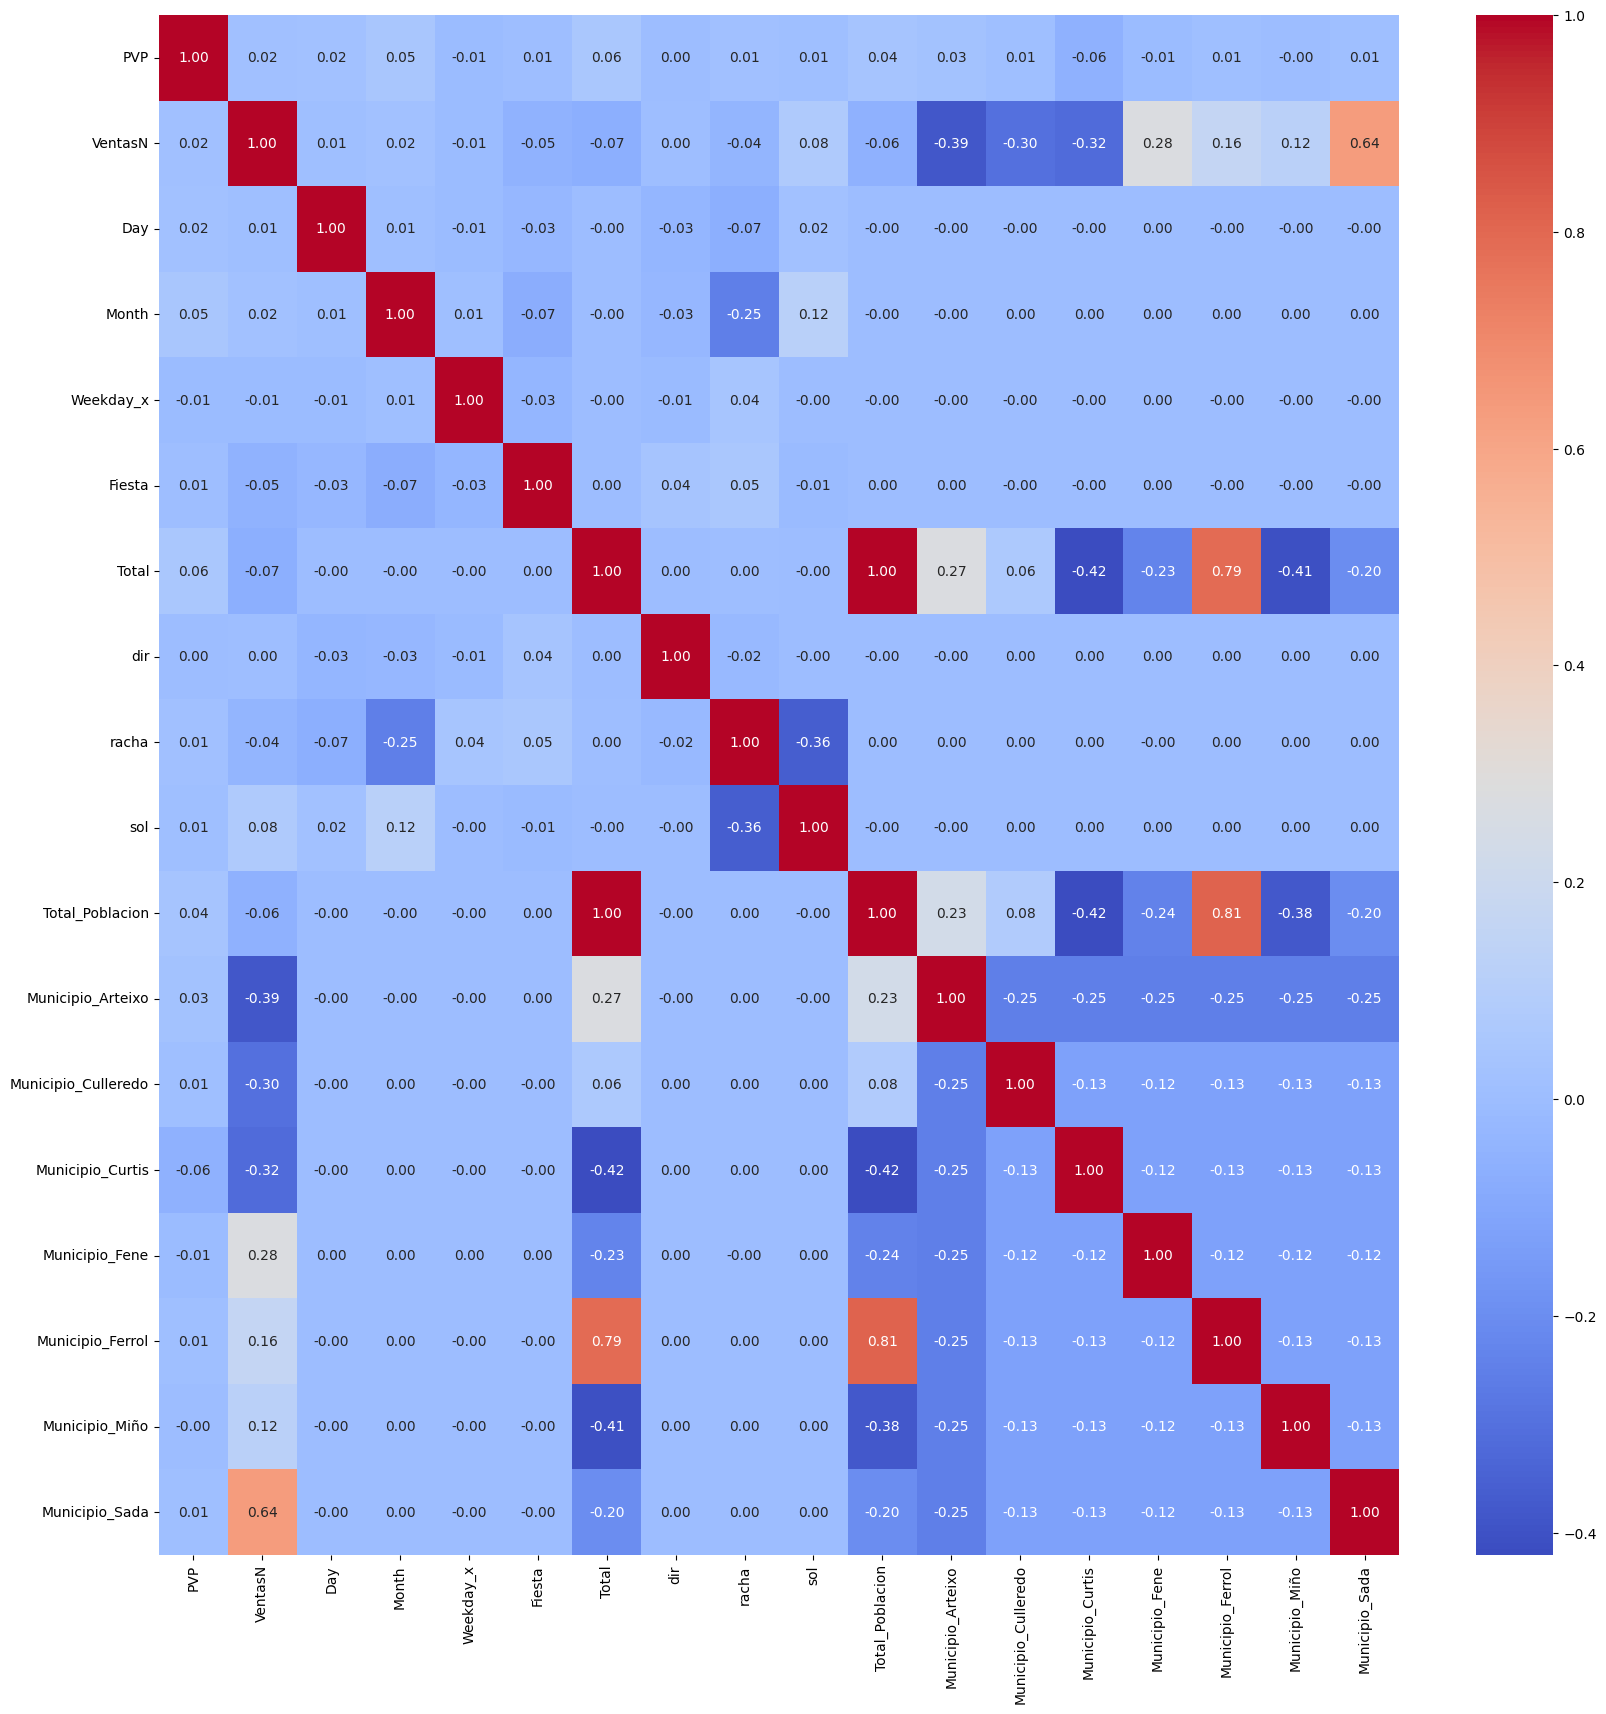

In [129]:
# Make the correlation of numerical variables for the 95 product
numerical_df95 = df95.drop(columns=["Producto","Nombre","prec","tmax","tmed","tmin","velmedia","presMax","presMin","altitud","Latitud","Longitud","Turismos","Autobuses","Motocicletas","Tractores industriales","Remolques y semirremolques","Otros vehículos","Camiones y furgonetas","Year"])
corr = numerical_df95.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

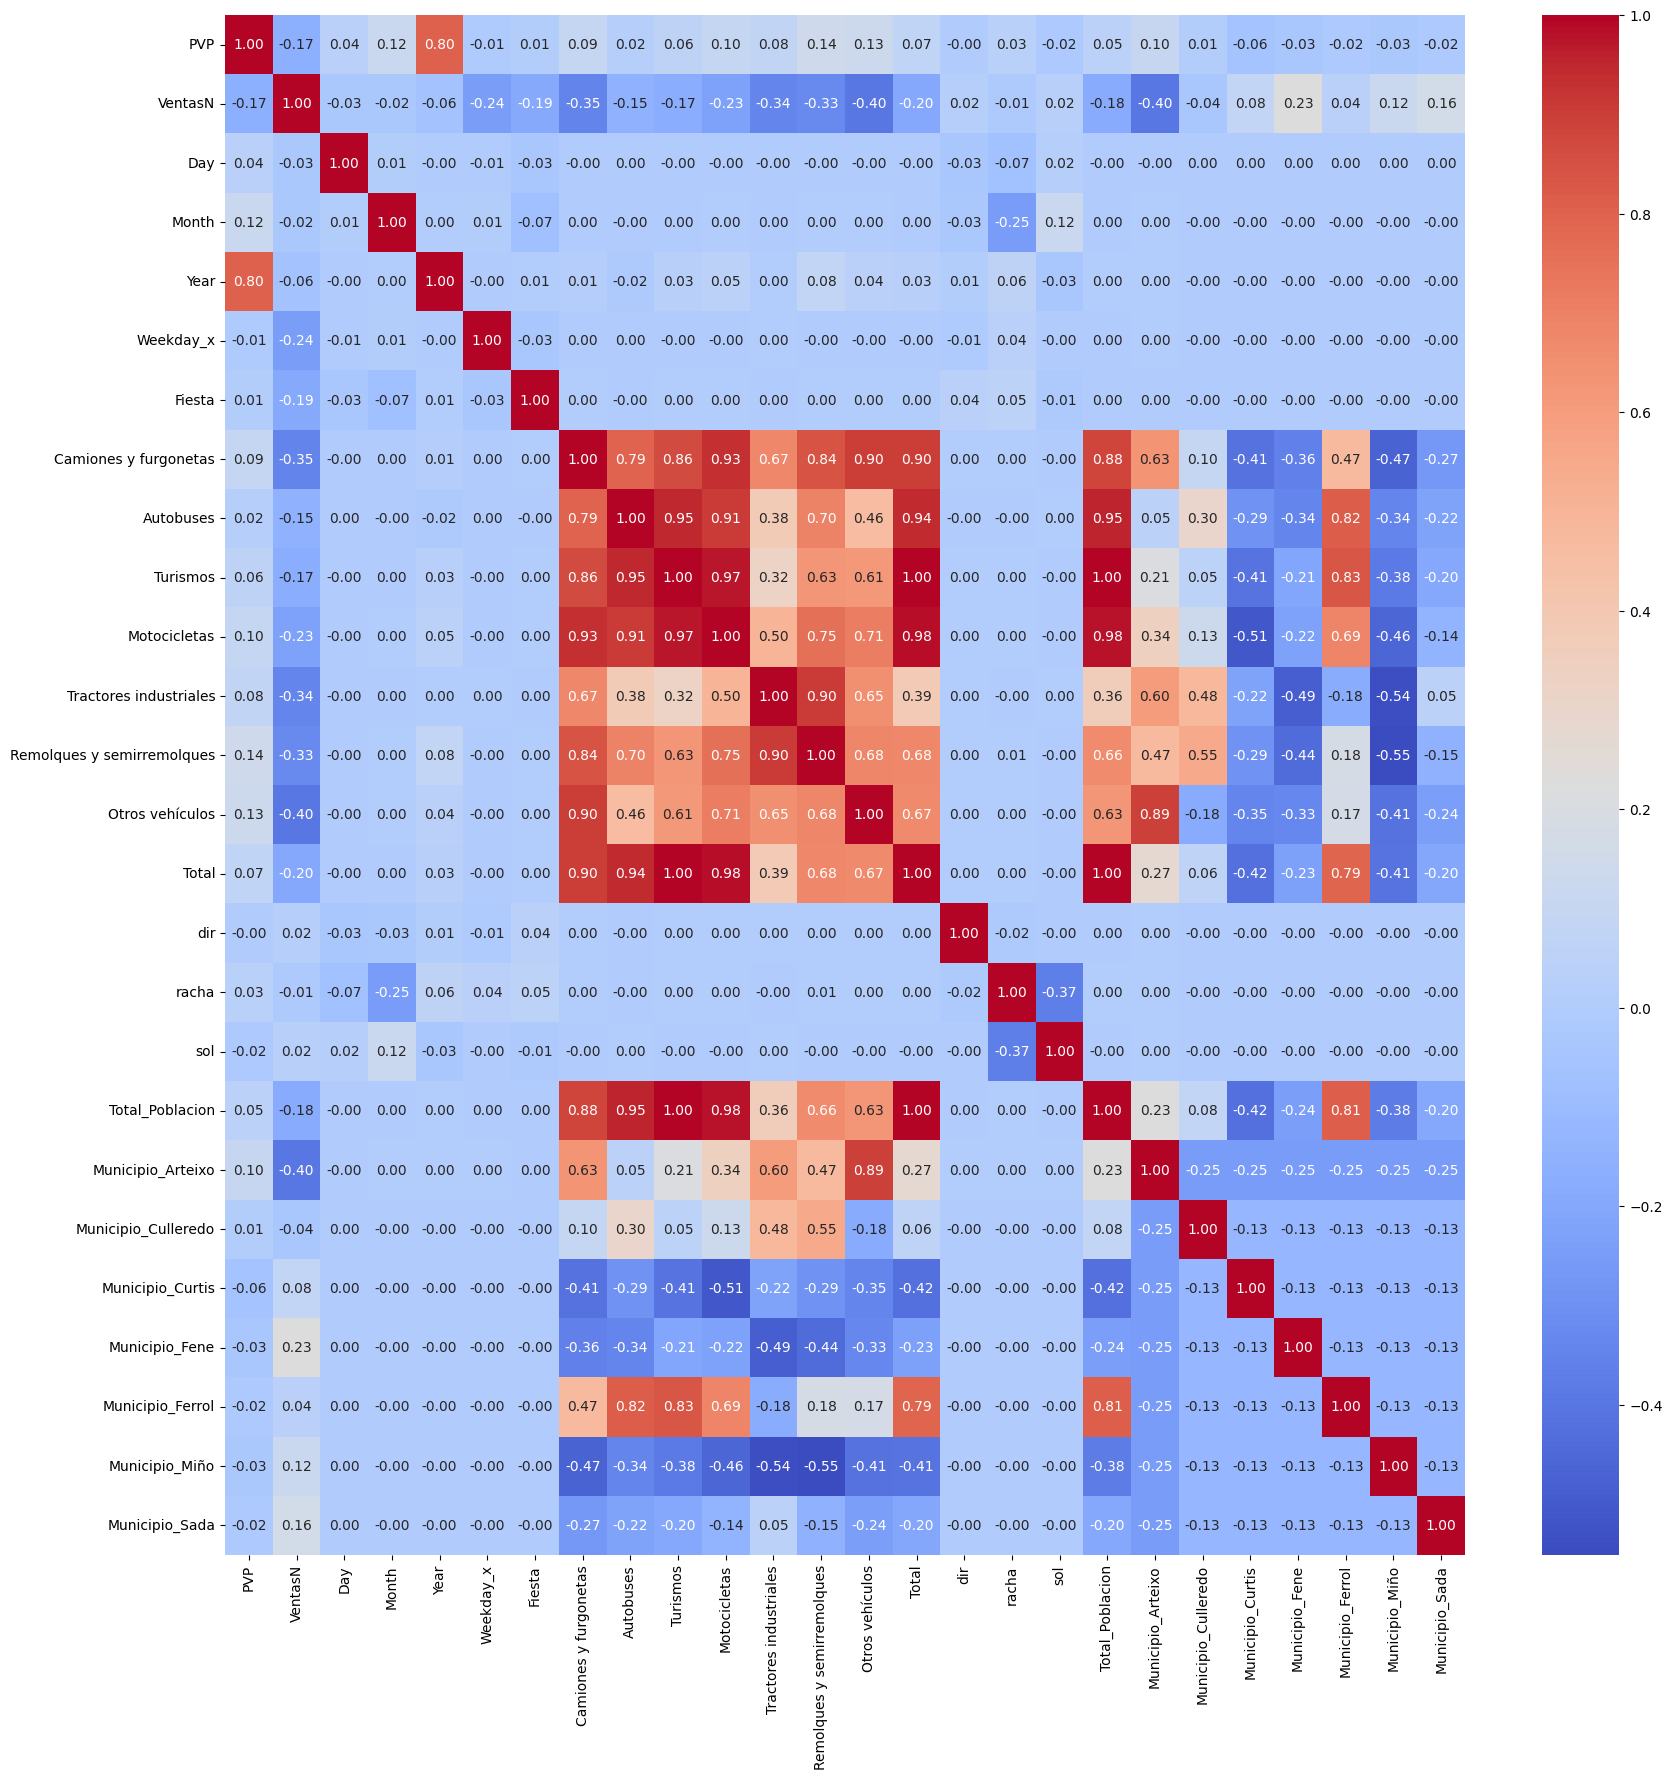

In [130]:
# Make the correlation of numerical variables for the GOA product
numerical_dfGOA = dfGOA.drop(columns=["Producto","Nombre","prec","tmax","tmed","tmin","velmedia","presMax","presMin","altitud","Latitud","Longitud"])
corr = numerical_dfGOA.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# 5. Preparing the dataset for the first model

Let's start with the product 95 

In [131]:
# Check null values
numerical_df95.isna().sum()
# Fill the null values in VentasN with the mean of the column (Since there were only 9 missing values)
numerical_df95['VentasN'] = numerical_df95['VentasN'].fillna(numerical_df95['VentasN'].mean())
# Fill the rest of null values with the mean (for meteo data, there were only 72 missing values)
numerical_df95= numerical_df95.fillna(numerical_df95.mean())

PVP                    0
VentasN                0
Day                    0
Month                  0
Weekday_x              0
Fiesta                 0
Total                  0
dir                    0
racha                  0
sol                    0
Total_Poblacion        0
Municipio_Arteixo      0
Municipio_Culleredo    0
Municipio_Curtis       0
Municipio_Fene         0
Municipio_Ferrol       0
Municipio_Miño         0
Municipio_Sada         0
dtype: int64

In [132]:
numerical_df95.head()

,PVP,VentasN,Day,Month,Weekday_x,Fiesta,Total,dir,racha,sol,Total_Poblacion,Municipio_Arteixo,Municipio_Culleredo,Municipio_Curtis,Municipio_Fene,Municipio_Ferrol,Municipio_Miño,Municipio_Sada
Dia,,,,,,,,,,,,,,,,,,
01/01/2016,1.169,0.050747,1,1,4,1,21543,18.0,19.4,1.8,31239,True,False,False,False,False,False,False
02/01/2016,1.169,0.173696,1,2,0,0,21543,22.0,5.8,0.0,31239,True,False,False,False,False,False,False
03/01/2016,1.169,0.132367,1,3,1,0,21543,28.0,10.3,7.2,31239,True,False,False,False,False,False,False
04/01/2016,1.169,0.134323,1,4,4,0,21543,29.0,6.4,11.7,31239,True,False,False,False,False,False,False
05/01/2016,1.159,0.132510,1,5,6,0,21543,34.0,13.1,13.7,31239,True,False,False,False,False,False,False


In [133]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming numerical_df95 is your prepared DataFrame with numerical data
# Replace 'numerical_df95' with your actual DataFrame name

# Split the data into X and y
X = numerical_df95.drop(columns=['VentasN'])
y = numerical_df95['VentasN']

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store train and test R2 scores
train_r2_scores = []
test_r2_scores = []

# Perform Time Series Cross Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize Lasso Regression model
    model = Lasso(alpha=0.1, random_state=42)  # Adjust alpha as needed for regularization

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate R2 scores
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Optionally calculate RMSE
    # train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    # test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Append scores to lists
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Optionally print or store RMSE
    # print(f"Train RMSE: {train_rmse}")
    # print(f"Test RMSE: {test_rmse}")

# Print average R2 scores
print(f"Train R2 scores: {train_r2_scores}")
print(f"Test R2 scores: {test_r2_scores}")
print(f"Average Train R2: {np.mean(train_r2_scores)}")
print(f"Average Test R2: {np.mean(test_r2_scores)}")


Train R2 scores: [0.016484007579451898, 0.010979728319901683, 0.3809207161317688, 0.15131463261732825, 0.056362142549812644]
Test R2 scores: [-0.2908315158826327, -3.297186925619015, -0.5019947933479696, -1.9993584227636854, -2.1355376133468438]
Average Train R2: 0.12321224543965266
Average Test R2: -1.6449818541920294


In [134]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming numerical_df95 is your prepared DataFrame with numerical data
# Replace 'numerical_df95' with your actual DataFrame name

# Split the data into X and y
X = numerical_df95.drop(columns=['VentasN'])
y = numerical_df95['VentasN']

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store train and test R2 scores
train_r2_scores = []
test_r2_scores = []

# Perform Time Series Cross Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize XGBoost model
    model = XGBRegressor(
        n_estimators=100,  # Example: you can adjust the number of trees
        max_depth=3,       # Example: limit tree depth to prevent overfitting
        learning_rate=0.1,  # Example: adjust learning rate
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate R2 scores
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append scores to lists
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Print average R2 scores
print(f"Train R2 scores: {train_r2_scores}")
print(f"Test R2 scores: {test_r2_scores}")
print(f"Average Train R2: {np.mean(train_r2_scores)}")
print(f"Average Test R2: {np.mean(test_r2_scores)}")


Train R2 scores: [0.5260352018501373, 0.4081937370731705, 0.7767693991941149, 0.83777961550633, 0.835911559670472]
Test R2 scores: [-0.09425344426073856, -2.388004516975115, -1.389723597699891, -0.13714215618136438, -3.9635687013969063]
Average Train R2: 0.6769379026588449
Average Test R2: -1.5945384833028031


In [135]:
importance = model.feature_importances_
feature_names = X.columns

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print feature importances
for i in range(len(feature_importance)):
    print(f"{feature_importance.iloc[i, 0]}: {feature_importance.iloc[i, 1]}")

Municipio_Sada: 0.7483479380607605
Municipio_Miño: 0.09774831682443619
Total: 0.08272252231836319
Total_Poblacion: 0.010935847647488117
Day: 0.008619220927357674
PVP: 0.008249500766396523
Municipio_Culleredo: 0.008239585906267166
Fiesta: 0.007357598282396793
Month: 0.006586206145584583
sol: 0.006199123803526163
Weekday_x: 0.00591930141672492
Municipio_Arteixo: 0.005570581182837486
racha: 0.0022081336937844753
dir: 0.0012960912426933646
Municipio_Curtis: 0.0
Municipio_Ferrol: 0.0
Municipio_Fene: 0.0


In [136]:
X.head()

,PVP,Day,Month,Weekday_x,Fiesta,Total,dir,racha,sol,Total_Poblacion,Municipio_Arteixo,Municipio_Culleredo,Municipio_Curtis,Municipio_Fene,Municipio_Ferrol,Municipio_Miño,Municipio_Sada
Dia,,,,,,,,,,,,,,,,,
01/01/2016,1.169,1,1,4,1,21543,18.0,19.4,1.8,31239,True,False,False,False,False,False,False
02/01/2016,1.169,1,2,0,0,21543,22.0,5.8,0.0,31239,True,False,False,False,False,False,False
03/01/2016,1.169,1,3,1,0,21543,28.0,10.3,7.2,31239,True,False,False,False,False,False,False
04/01/2016,1.169,1,4,4,0,21543,29.0,6.4,11.7,31239,True,False,False,False,False,False,False
05/01/2016,1.159,1,5,6,0,21543,34.0,13.1,13.7,31239,True,False,False,False,False,False,False


## AutoRegressive Integrated Moving Average with eXogenous variables

-------------------------------------------------------------------------------------------------------------------------------------------------